# 使用`LowLevelCallable`提高回调函数的运行速度

Python的函数调用比较费时，这样当需要大量回调函数时，即使主循环程序采用C语言编写也不能有效地提高程序的运行速度。在Scipy 0.19中提供了`LowLevelCallable`对C、Cython或者numba编写的函数进行包装，让主循环能够快速调用这些函数。目前支持`LowLevelCallable`的函数还不多，这里以`integrate.quad()`和`ndimage.geometric_transform()`为例，介绍`LowLevelCallable`的用法。

## `quad()`计算积分

In [1]:
import scipy
import math
import numpy as np
from scipy import integrate

In [2]:
def normal_pdf(x, μ, σ):
    d = math.sqrt(2 * math.pi * σ**2)
    return math.exp(-(x - μ)**2 / (2 * σ**2)) / d

In [3]:
integrate.quad(normal_pdf, -100, 100, args=(0, 1))

(1.0000000000000002, 1.0347170600110818e-12)

In [4]:
from numba import cfunc
from numba import types as T
from scipy import LowLevelCallable

@cfunc(T.double(T.int32, T.CPointer(T.double)), nopython=True)
def normal_pdf_fast(n, data):
    x, μ, σ = data[0], data[1], data[2]
    d = math.sqrt(2 * math.pi * σ**2)
    return math.exp(-(x - μ)**2 / (2 * σ**2)) / d    

from scipy import LowLevelCallable
llc = LowLevelCallable(normal_pdf_fast.ctypes)
integrate.quad(llc, -100, 100, args=(0, 1))

(1.0000000000000002, 1.0347170600110818e-12)

In [5]:
%timeit integrate.quad(normal_pdf, -0.5, 0.5, args=(0, 1))
%timeit integrate.quad(llc, -0.5, 0.5, args=(0, 1))

58.4 µs ± 2.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4.43 µs ± 40.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## `geometric_transform()`对图像进行几何变形

`ndimage.geometric_transform()`将图像上每点的坐标传递给回调函数，得到几何变换之后的坐标。下面使用它实现图像的旋转。

In [19]:
from scipy import ndimage
from PIL import Image
import ctypes

img = ndimage.imread("flower.jpg")

In [13]:
def trans_func_py(pos, h, w):
    r, c, d = pos
    x, y = c - w / 2, r - h / 2
    dist = math.hypot(x, y)
    angle = math.atan2(y, x) + math.radians(30)
    x, y = dist * math.cos(angle), dist * math.sin(angle)
    return y + h / 2, x + w / 2, d

%time new_img = ndimage.geometric_transform(img, trans_func_py, order=1, extra_arguments=img.shape[0:2])

Wall time: 520 ms


`LowLevelCallable`对象在调用时，会使用其`signature`属性判断函数的参数类型是否正确。由于numba创建的ctypes函数的调用参数类型的字符串与`geometric_transform()`所需的类型字符串不匹配，因此这里在创建`LowLevelCallable`对象时直接设置其`signature`属性。

Wall time: 69 ms


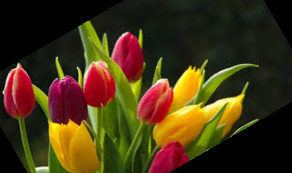

In [18]:
@cfunc(T.int_(T.CPointer(T.intp), T.CPointer(T.double), T.int_, T.int_, T.CPointer(T.int_)))
def trans_func_nb(out_coord, in_coord, out_rank, in_rank, data):
    h = data[0]
    w = data[1]
    r = out_coord[0]
    c = out_coord[1]
    d = out_coord[2]
    x = c - w / 2
    y = r - h / 2
    dist = math.hypot(x, y)
    angle = math.atan2(y, x) + math.radians(30)
    x, y = dist * math.cos(angle), dist * math.sin(angle)
    in_coord[0] = y + h / 2
    in_coord[1] = x + w / 2
    in_coord[2] = d
    return 1

data = (ctypes.c_int32 * 2)(img.shape[0], img.shape[1])
llc = LowLevelCallable(trans_func_nb.ctypes, 
                       signature='int (long long *, double *, int, int, void *)',
                       user_data=ctypes.cast(data, ctypes.c_void_p))
%time new_img2 = ndimage.geometric_transform(img, llc, order=1)
Image.fromarray(new_img2)